**Breakout with DQN - playing the game**

Team: Happy Campers

In [ ]:
#!pip install gym
#!apt-get install python-opengl -y
#!apt install xvfb -y

In [ ]:
%matplotlib inline
from gym import wrappers
from time import sleep
import time
import gym
import math
import random
import numpy as np
import statistics as st
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn #contains everything needed to build neural networks
import torch.optim as optim

#interacting with the file system
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display
import torch.nn.functional as F
import torchvision.transforms as T

Mounted at /content/gdrive


In [ ]:
# DQN from the google deep mind paper
class DQN(nn.Module): #extends nn. module
    def __init__(self, img_height, img_width, num_frames=4): #screenshot-like images as input
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4) #four hidden convolutional layers and an output layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.dense = torch.nn.Linear(64 * 7 * 7, 512)
        self.out = nn.Linear(512, 4)   # four outputs - our action space       


  # implements a forward pass through the network     
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.relu(self.conv2(t))
        t = F.relu(self.conv3(t))
        t = t.view(t.size(0), -1)
        t = F.relu(self.dense(t))
        t = self.out(t)
        return t

In [ ]:
#class experience that creates instances of experience objects that will get stored in replay memory
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [ ]:
# stores experiences
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] #holds stored experiences
        self.push_count = 0 #how many experiences we've added

    # pushes new experience to memory 
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience #we push new experiences, replacing the oldest ones first
        self.push_count += 1

    # samples the number of experiences from memory that match the batch size
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    #we can only provide a sample if the number of experiences is higher or equal to batch size
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [ ]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

In [ ]:
class Agent():
    def __init__(self, strategy, num_actions, device): # device we use for tensor calculations
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

In [ ]:
#plot results while playing
def plot(values, moving_avg_period, time_taken):
    plt.figure(2)
    plt.clf()        
    #plt.title('Playing...')
    plt.xlabel('Episode')
    plt.ylabel('Points')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode moving avg:", moving_avg[-1])
    #print(f"Episode times: {time_taken[-1]} (s)")
    print("Max score: ", max(values).cpu().detach().numpy()[0])
    print("Min score: ", min(values).cpu().detach().numpy()[0])
    print("Median score: ", st.median(values).cpu().detach().numpy()[0])
    print("Average score: ", sum(values).cpu().detach().numpy()[0] / len(values))
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [ ]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [ ]:
class QValues():
  # we create a device since we won't be creating an instance of this class
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions): 
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1)) #pytorch tensor
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values #maxim q values for next states, return pytorch tensor

In [ ]:
# we encapsulate the environment functionalities in the environment manager
class BreakoutEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('BreakoutNoFrameskip-v4').unwrapped
        self.env = wrappers.AtariPreprocessing(self.env)
        self.env = wrappers.FrameStack(self.env, num_stack = 4)
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
        
    def num_actions_available(self):
        return self.env.action_space.n
        
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        self.current_screen = self.get_processed_screen()
        return self.current_screen

    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        #print(screen, "Get height", screen.shape)
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
       
    def get_processed_screen(self):
        #frame = np.array(obs[0])[f]
        screen = np.asarray(self.env.frames) # PyTorch expects CHW
        #print("Screen shape get process", screen.shape)
        return self.transform_screen_data(screen)
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        #print("Shape screen", screen.shape)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        return screen.unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

In [ ]:
batch_size = 256
gamma = 0.995
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.00001
num_episodes = 1001
configuration = 6 # We have different configurations of parameters - the variable serves for saving the model configurations = {0,1,2,3,4,5,6}

last_ep_cp = 0
#Load model
last_ep_cp = 12500
model_save_name = f'classifier_{last_ep_cp}_config_{configuration}.pt'
path = f"/content/gdrive/My Drive/models/{model_save_name}"
checkpoint = torch.load(path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

em = BreakoutEnvManager(device)



strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
#agent gives you the proper epsilon value
agent = Agent(strategy, em.num_actions_available(), device)
agent.current_step = checkpoint['agent_current_step']
memory = ReplayMemory(memory_size)

# load the target and policy networks from the loaded model
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
policy_net.load_state_dict(checkpoint['policy_state_dict'])
policy_net.eval()

target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(checkpoint['target_state_dict'])

target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
optimizer.load_state_dict(checkpoint['optimizer'])

episode_points = []
episode_times = []


for episode in range(last_ep_cp+1, last_ep_cp+num_episodes):

    start_time = time.time()
    em.reset()
    total_reward = 0
    state = em.get_state()

    for timestep in count():

        #select and perform action, record reward and next state
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        total_reward += reward
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
            
        if em.done:
            episode_points.append(total_reward)

            end_time = time.time()
            time_elapsed = end_time - start_time
            episode_times.append(time_elapsed)

            #print the episode every 100 episodes
            if len(episode_points) % 100 == 0:
              print(len(episode_points))
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()

cuda
100
200
300
400
500
600
700
800
900
1000


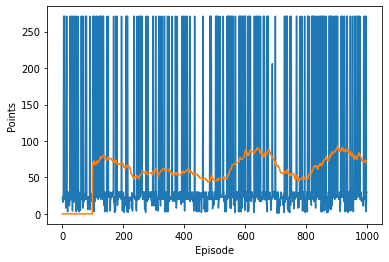

Episode 1000 
 100 episode moving avg: 71.16
Max score:  271.0
Min score:  1.0
Median score:  23.0
Average score:  65.832


In [ ]:
plot(episode_points, 100, episode_times)